# Lab 8 Label Propagation

## Due: Midnight, April 19th
In this lab, we will learn
- Label Propagation for Node Classification on Graphs
- Applying Label Propaation for Semi-supervised Classification (no graph is given, cosntruct graph with feature similarity)


## Save Your Notebook! 
- Click on File (upper left corner), Select “Save and Checkpoint”.
- Important: You may loose your modification to a notebook if you do not Save it explicitly.
- Advice: Save and Checkpoint often.  


## Submission
- Please follow the instructions and finish the exercises.
- After you finish the lab, please Click on File, Select “Download as”, Choose Notebook (.ipynb)
- After download is complete, Click on File, Select “Download as” again, Choose PDF via Latex (.pdf)
- Submit both the Notebook file and the PDF File as your submission for Lab 8.

# 1. Preparation
Before we start to visualize the networks, we have to install the packages and prepare the network dataset. 
# 1.1. Install Packages
The following packages should be avaialbe in Azure. In case not, uncomment and run the following codes

In [ ]:
# !pip install matplotlib
# !pip install networkx
# !pip install numpy

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## 1.2 Load and visualize the karate club dataset 
It is collected from the members of a university karate club by Wayne Zachary. <br>
* The matrix represents the presence or absence of ties among the members of the club; <br>
* Each node is associated with a label, either 0 or 1

In [2]:
# load the karate club dataset
G=nx.karate_club_graph()
y_true = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

visualize the graph <br>
**red** indicates 0 and **blue** indicates 1

In [3]:
def plot_graph(G,pos,y,ax):
    cls1color='tab:blue'
    cls2color='tab:red'
    unlabel = 'tab:orange'
    node_colors = []
    for label in y:
        if label==0:
            node_colors.append(cls1color)
        elif label==1:
            node_colors.append(cls2color)
        else:
            node_colors.append(unlabel)
    nx.draw_networkx(G, pos, node_color=node_colors,ax=ax, with_labels=True, node_size=300)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


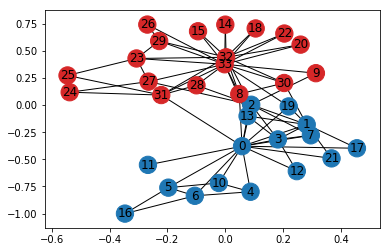

In [4]:
%matplotlib inline
fig, ax = plt.subplots()
pos = nx.fruchterman_reingold_layout(G)
plot_graph(G,pos,y_true,ax)

# 2. Label propagation
Label propagation is a semi-supervised machine learning algorithm that assigns labels to previously unlabeled data points. At the start of the algorithm, a (generally small) subset of the data points have labels. These labels are propagated to the unlabeled points throughout the course of the algorithm. <br>

Here is the algorithm of label propagation: <br>
**Input**: adjacency matrix $A$, provided partial labels $Y_I$ <br>
**Output**: The predicted for all data $\hat{Y}$ <br>
1. Compute the degree $D_i=\sum_j{A_{ij}}$
2. Normalize the adjacency matrix: $P=D^{-1}A$
3. Initialize $Y^{(0)}=(Y_I,Y_U), t=0$, the unlabled data could all be initialized as negative (0).
4. **Repeat** <br>
    $Y^{t+1} \leftarrow PY^{(t)}$, this is the process of propagating the labels from the labeled data to unlabeled one <br>
    $Y^{t+1}_{I} \leftarrow Y_I$, last step may change the labels of labeled data, here we keep the $\hat{Y_I}$ the sames as $Y_I$
   **untill** $Y^{(t)}$ converges;
5. Get the predictions  $\hat{Y} \leftarrow Y^{t+1}$

The process of the label propagation on karate clud dataset is shown below (orange: unlabeled, blue: class 1, red: class 0): <br>
![Alt Text](graph.gif)

## 2.1 Implementation
* **set_label_y**: $Y^{t+1}_{I} \leftarrow Y_I$
* **is_converge**: check whehter it meets the converging criterion
* **label_propagation**: The function implement Label propagation 


In [5]:
def set_label_y(y,label_nodes,labels):
    """
    This function set Y^{t+1}_{I} \leftarrow Y_I, i.e., make the set of labeled data
    to have the groundtruth label assignment.
    y: stores Y^{t+1}
    label_nodes: the set of initially labeled nodes
    labels: the corresponding label of the label_nodes
    """
    for node,label in zip(label_nodes,labels):
        one_hot = np.zeros([2],dtype=int)
        one_hot[label] = 1
        y[node] = one_hot
    return y

In [6]:
def is_converge(y1,y2,e=1e-4):
    """
    if the change of concecutive label distribution y1, y2
    is less than a thesshold e=1e-4, then the algorithm converges
    y1: Y^{t-1}
    y2: Y^{t}
    """
    change = np.max(np.abs(y1-y2))
    if(change < e):
        return True
    return False

In [7]:
def label_propagation(A,label_nodes,labels,y_max_iter,show_iter=-1):
    """
    A: adjacency matrix of the graph, numpy array
    label_nodes: The positions of nodes which have labels, numpy  array
    labels: The labels of the label nodes
    y_max_iter: The max iterations steps
    show_iter: if it is -1, the output will only have predicted labels.
               if it is larger than 0, a history of the predicted labels
               during the propagation process will also be returned. The
               interval is show_iter.
    
    """
    
    # initialize the label dirstribution of all the nodes
    y_init = np.zeros([A.shape[0],2])
    y_init[:,1] = 1
    y = set_label_y(y_init,label_nodes,labels) # set the labeled nodes to their ground truth label
    
    history_labels = [] # we stor how the label changes in history_labels for visualization purpose
    for i in range(max_iter):
        y_old = y.copy()
        
        y = A/A.sum(axis=0,keepdims=True).T@y  # updating as Y^{t+1} \leftarrow PY^{(t)}
        y = set_label_y(y,label_nodes,labels)  # set the labeled nodes to their ground truth label
        
        pred_labels = np.argmax(y,axis=1)
        if show_iter > 0 and i%show_iter==0:
            history_labels.append(pred_labels)
            
        if(is_converge(y_old,y,e=1e-4)):
            break
        
    if show_iter > 0:
        return pred_labels,history_labels
    
    return pred_labels

### Start label propagation
1. Here we first set the node 0 and node 33 as labeled data.
2. Next we use the label propagation function get the labels $\hat{Y}$

In [8]:
# set the labeled nodes
# Here we only give labels to two nodes
# node 0 with label 0 (red) and node 33 with label 1 (blue)
label_nodes=np.asarray([0,33],dtype=int) 
labels = np.asarray([0,1],dtype=int)

### Visualize the data initial status
* red indicates 0,
* blue indicates 1,
* orange indicates unlabeled

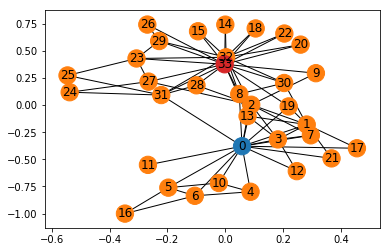

In [9]:
# visualize 

y = np.full_like(y_true,-1)
for i,node in enumerate(label_nodes):
    y[node] = labels[i]
fig, ax = plt.subplots()
plot_graph(G,pos,y,ax)

In [10]:
# label propagation
max_iter = 100
A = np.asarray(nx.adjacency_matrix(G).todense())
pred_labels,history_labels = label_propagation(A,label_nodes,labels,max_iter,show_iter=3)

print(pred_labels)

[0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


### Plot the final reuslt of label propagation
red indicates 0, blue indicates 1 

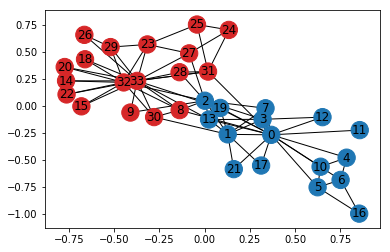

In [11]:
%matplotlib inline
fig, ax = plt.subplots()
pos = nx.fruchterman_reingold_layout(G)
plot_graph(G,pos,pred_labels,ax)
plt.show()

## 2.2 Visualize the propagation process through animation

### Generate animation

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


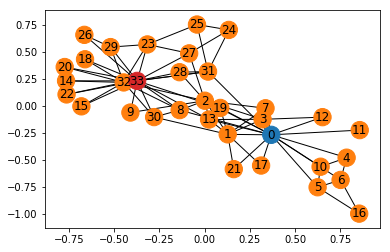

In [12]:
import matplotlib.animation as animation
fig, ax = plt.subplots()
def draw_graph(i):
    if i==0:
        y = np.full_like(y_true,-1)
        for i,node in enumerate(label_nodes):
            y[node] = labels[i]
        plot_graph(G,pos,y,ax)
    else:
        plot_graph(G,pos,history_labels[i-1],ax)

# ani is the animation object 
ani = animation.FuncAnimation(fig, draw_graph, frames=len(history_labels)+1)

### Save the animation as gif

In [13]:
from matplotlib.animation import PillowWriter    
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(1000 / self.fps), loop=0)

In [14]:
ani.save('graph.gif', writer=LoopingPillowWriter(fps=2))

### Interactively display the animation in jupyter notebook


In [15]:
from IPython.display import HTML
HTML(ani.to_jshtml())

## Exercise 1. Evaluate the prediction 
Please implement the **accuracy** metric to evaluate the results of the predicted labels $\hat{Y}$
\begin{equation}
    accuracy = \frac{1}{|V_U|}\sum_{v_i \in V_U}  I(\hat{Y}(v_i) == Y(v_i)) 
\end{equation}
where $V_U$ is the set of unlabeled nodes, $\hat{Y}(v_i)$ is the predicated label for node $v_I$ and $Y(v_i)$ is the groundtruth label for node $v_i$.

In our case, the predicted labels are stored in pred_labels, the groundtruth labels are stored in y_true, labeled nodes are in label_nodes. Tp help you get started, we have provided the following codes

In [22]:
unlabeled_nodes = [node for node in G.nodes() if node not in label_nodes] # the set of unlabeled data
print(pred_labels[unlabeled_nodes])  # the preded labels for unlabeled data
print(np.asarray(y_true)[unlabeled_nodes])  # the ground truth of the labeled data

# TODO: Please calculate the accurac
t = 0
for i in range(len(pred_labels[unlabeled_nodes])):
    if pred_labels[unlabeled_nodes][i] == 1 and np.asarray(y_true)[unlabeled_nodes][i] == 1:
        t += 1
accuracy = t/len(unlabeled_nodes)
print("The accuracy of the label propagation is: {}".format(accuracy))

[0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1]
The accuracy of the label propagation is: 0.53125


## Exercise 2
In the experiment, we choose node 0 and node 33 as labeled data. <br>
Using different nodes and different number of labeled data may bring different results. <br>
Please try node 16 (lable 0) and node 24 (label 1) as labeled nodes and run the label propagation. Please visualize the final prediction and calculate the accuracy

In [23]:
## TO DO
label_nodes=np.asarray([16,24],dtype=int) 
labels = np.asarray([0,1],dtype=int)

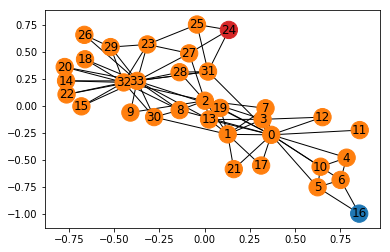

In [24]:
y = np.full_like(y_true,-1)
for i,node in enumerate(label_nodes):
    y[node] = labels[i]
fig, ax = plt.subplots()
plot_graph(G,pos,y,ax)

In [25]:
max_iter = 100
A = np.asarray(nx.adjacency_matrix(G).todense())
pred_labels,history_labels = label_propagation(A,label_nodes,labels,max_iter,show_iter=3)

print(pred_labels)

[1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


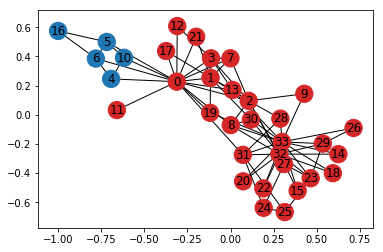

In [26]:
%matplotlib inline
fig, ax = plt.subplots()
pos = nx.fruchterman_reingold_layout(G)
plot_graph(G,pos,pred_labels,ax)
plt.show()

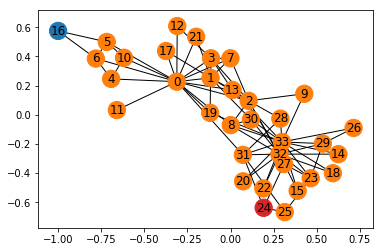

In [27]:
import matplotlib.animation as animation
fig, ax = plt.subplots()
def draw_graph(i):
    if i==0:
        y = np.full_like(y_true,-1)
        for i,node in enumerate(label_nodes):
            y[node] = labels[i]
        plot_graph(G,pos,y,ax)
    else:
        plot_graph(G,pos,history_labels[i-1],ax)

# ani is the animation object 
ani = animation.FuncAnimation(fig, draw_graph, frames=len(history_labels)+1)

In [28]:
unlabeled_nodes = [node for node in G.nodes() if node not in label_nodes] # the set of unlabeled data
print(pred_labels[unlabeled_nodes])  # the preded labels for unlabeled data
print(np.asarray(y_true)[unlabeled_nodes])  # the ground truth of the labeled data

# TODO: Please calculate the accurac
t = 0
for i in range(len(pred_labels[unlabeled_nodes])):
    if pred_labels[unlabeled_nodes][i] == 1 and np.asarray(y_true)[unlabeled_nodes][i] == 1:
        t += 1
accuracy = t/len(unlabeled_nodes)
print("The accuracy of the label propagation is: {}".format(accuracy))

[1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1]
The accuracy of the label propagation is: 0.53125


# 3. Label propagation without explict graph
When there is not explicit graph available, we could build graph based on the attributes of data points. <br>
One way is to use RBF kernel to assign a weight $w_{ij}$ between two data points $X_i$ and $X_j$. The equation is <br>
\begin{equation}
w_{ij}=\exp(\frac{\|X_i-X_j\|^2}{2\sigma^2})
\end{equation}
$\|X_i-X_j\|^2$ measures the Euclidean distance of $X_i$ and $X_j$. The more close $X_i$ and $X_j$ is (smaller $\|X_i-X_j\|^2$), the larger the weight $w_{ij}$ is. Then, we could normalize the $W$ to get the adjacency matrix $A$ 
\begin{equation}
A_{ij}=\frac{w_{ij}}{\sum_j{w_{ij}}}
\end{equation}



In [29]:
def buildGraph(MatX, rbf_sigma = None):
    """
    This function is used to build the graph based on the MatX
    MatX: a matrix with each row as a data sample
    """
    num_samples = MatX.shape[0]
    affinity_matrix = np.zeros((num_samples, num_samples), np.float32)
    if rbf_sigma == None:
        raise ValueError('You should input a sigma of rbf kernel!')
    for i in range(num_samples):
        diff = MatX[i] - MatX
        affinity_matrix[i] = np.exp(np.sum(diff**2,axis=1) / (-2.0 * rbf_sigma**2))
        affinity_matrix[i] = affinity_matrix[i]/affinity_matrix[i].sum()  
    return affinity_matrix

In [30]:
import math
def show(Mat_Label, labels, Mat_Unlabel, unlabel_data_labels,ax): 
    """
    This function is used to visualize the data
    """
    import matplotlib.pyplot as plt 
    for i in range(Mat_Label.shape[0]):
        if int(labels[i]) == 0:  
            ax.plot(Mat_Label[i, 0], Mat_Label[i, 1], color="tab:red",marker='D')  
        elif int(labels[i]) == 1:  
            ax.plot(Mat_Label[i, 0], Mat_Label[i, 1], color="tab:blue",marker='D')
        else:
            ax.plot(Mat_Label[i, 0], Mat_Label[i, 1], color="tab:orange",marker='D')
    
    for i in range(Mat_Unlabel.shape[0]):
        if int(unlabel_data_labels[i]) == 0:  
            ax.plot(Mat_Unlabel[i, 0], Mat_Unlabel[i, 1], color="tab:red",marker='o')  
        elif int(unlabel_data_labels[i]) == 1:  
            ax.plot(Mat_Unlabel[i, 0], Mat_Unlabel[i, 1], color="tab:blue",marker='o')
        else:
            ax.plot(Mat_Unlabel[i, 0], Mat_Unlabel[i, 1], color="tab:orange",marker='o',markersize=3)

def loadCircleData(num_data):
    """
    This function is used to generate circle data for demonstration purpose
    You will see what the generated data looks like in the visualization
    """
    center = np.array([5.0, 5.0])
    radiu_inner = 2
    radiu_outer = 4
    num_inner = int(num_data / 3)
    num_outer = num_data - num_inner
    
    data = []
    theta = 0.0
    for i in range(num_inner):
        pho = (theta % 360) * math.pi / 180
        tmp = np.zeros(2, np.float32)
        tmp[0] = radiu_inner * math.cos(pho) + np.random.rand(1) + center[0]
        tmp[1] = radiu_inner * math.sin(pho) + np.random.rand(1) + center[1]
        data.append(tmp)
        theta += 2
    
    theta = 0.0
    for i in range(num_outer):
        pho = (theta % 360) * math.pi / 180
        tmp = np.zeros(2, np.float32)
        tmp[0] = radiu_outer * math.cos(pho) + np.random.rand(1) + center[0]
        tmp[1] = radiu_outer * math.sin(pho) + np.random.rand(1) + center[1]
        data.append(tmp)
        theta += 1
    
    Mat_Label = np.zeros((2, 2), np.float32)
    Mat_Label[0] = center + np.array([-radiu_inner + 0.5, 0])
    Mat_Label[1] = center + np.array([-radiu_outer + 0.5, 0])
    labels = [0, 1]
    Mat_Unlabel = np.vstack(data)
    return Mat_Label, labels, Mat_Unlabel

## 3.1 Load and visualize the circle data
### Generate an artifical dataset 
This artificial dataset contains two circles.<br>
One circle is inner. Another one is outer.

In [31]:
# generate 800 unlabel data points, 2 labeled data
num_unlabel_samples = 800
Mat_Label, labels, Mat_Unlabel = loadCircleData(num_unlabel_samples)

all_data = np.vstack((Mat_Label,Mat_Unlabel))
label_nodes=np.asarray([0,1],dtype=int)

### Visualize the dataset
* Large blue indicates point from the outter circle
* Large red indicates point from the inner circle
* Small orange indicateis unlabled data

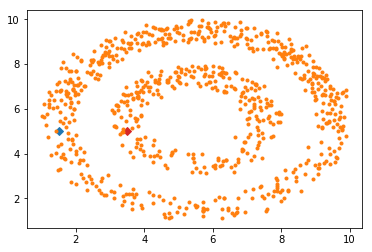

In [32]:
fig, ax = plt.subplots()
show(Mat_Label, labels, Mat_Unlabel, np.full([num_unlabel_samples],-1),ax)
plt.show()

## 3.2 Label propagation on the circle data
After using the buildGraph function the get adjacency matrix $A$, we could simply using the same process in section 2. <br>
The propagation process would be like:
![Alt text](circle.gif)

In [33]:
# the cell to do the label propagation
max_iter = 5000
A = buildGraph(all_data,rbf_sigma=0.15)
pred_labels,history_labels = label_propagation(A,label_nodes,labels,max_iter,show_iter=500)
unlabel_data_labels = pred_labels[2:]

### Plot the reuslt of label propagation

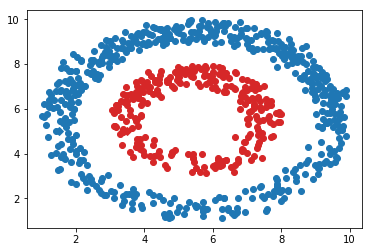

In [34]:
fig, ax = plt.subplots()
show(Mat_Label, labels, Mat_Unlabel, unlabel_data_labels,ax)

## 3.3 Visualize the propagation process through animation

### Generate the animation

<Figure size 432x288 with 0 Axes>

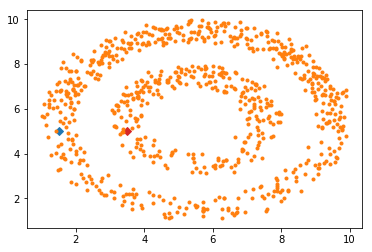

In [35]:
import matplotlib.animation as animation
plt.clf()
fig, ax = plt.subplots()
def draw_circle(i):
    if i==0:
        show(Mat_Label, labels, Mat_Unlabel, np.full([num_unlabel_samples],-1),ax)
    else:
        show(Mat_Label, labels, Mat_Unlabel, history_labels[i-1][2:],ax)
ani = animation.FuncAnimation(fig, draw_circle, frames=len(history_labels)+1)

### Save the animation as gif
It may take a few minutes to finish this cell. <br> 
Your don't have to rerun this cell. <br>
Sometimes, the saved gif is imcomplete on azure, re-runing may be helpful. It may take few minutes to generate the gif. Please be patient.

In [36]:
ani.save('circle.gif', writer=LoopingPillowWriter(fps=2))

### Interactively display the animation in jupyter notebook
It may take a few minutes to finish this cell. <br>
Your don't have to rerun this cell. <br>

In [37]:
from IPython.display import HTML
HTML(ani.to_jshtml())

## Exercise 3
In this section, we set the $\sigma$ as 0.15, which gives us nice results. <br>
* If the $\sigma$ is small, the prediction of one point will care more about the points near it. <br>
* If the $\sigma$ is large, the prediction of one point will pay more attention to the points away from it. <br>

Please change the value of $\sigma$ as ${0.1, 0.5, 1, 10, 100}$, and explore how the $\sigma$ will influence the final results. For this question, please don't generate visualization as it may take some time. You can just observe the final visualization.


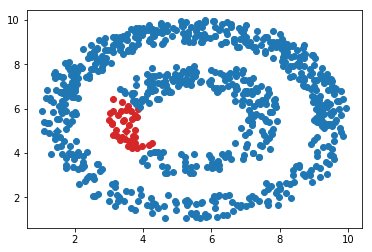

In [46]:
max_iter = 5000
A = buildGraph(all_data,rbf_sigma=0.1)
pred_labels,history_labels = label_propagation(A,label_nodes,labels,max_iter,show_iter=500)
unlabel_data_labels = pred_labels[2:]

fig, ax = plt.subplots()
show(Mat_Label, labels, Mat_Unlabel, unlabel_data_labels,ax)

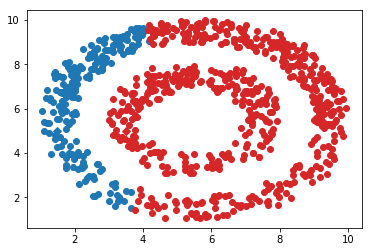

In [41]:
max_iter = 5000
A = buildGraph(all_data,rbf_sigma=0.5)
pred_labels,history_labels = label_propagation(A,label_nodes,labels,max_iter,show_iter=500)
unlabel_data_labels = pred_labels[2:]

fig, ax = plt.subplots()
show(Mat_Label, labels, Mat_Unlabel, unlabel_data_labels,ax)

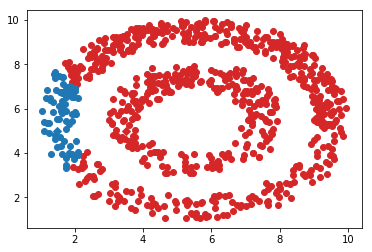

In [42]:
max_iter = 5000
A = buildGraph(all_data,rbf_sigma=1)
pred_labels,history_labels = label_propagation(A,label_nodes,labels,max_iter,show_iter=500)
unlabel_data_labels = pred_labels[2:]

fig, ax = plt.subplots()
show(Mat_Label, labels, Mat_Unlabel, unlabel_data_labels,ax)

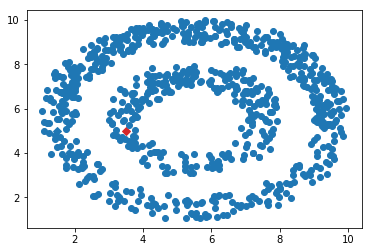

In [43]:
max_iter = 5000
A = buildGraph(all_data,rbf_sigma=10)
pred_labels,history_labels = label_propagation(A,label_nodes,labels,max_iter,show_iter=500)
unlabel_data_labels = pred_labels[2:]

fig, ax = plt.subplots()
show(Mat_Label, labels, Mat_Unlabel, unlabel_data_labels,ax)

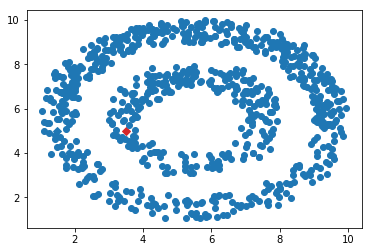

In [44]:
max_iter = 5000
A = buildGraph(all_data,rbf_sigma=100)
pred_labels,history_labels = label_propagation(A,label_nodes,labels,max_iter,show_iter=500)
unlabel_data_labels = pred_labels[2:]

fig, ax = plt.subplots()
show(Mat_Label, labels, Mat_Unlabel, unlabel_data_labels,ax)

Based on the results you observe, how different $\sigma$ affects the final results?
Answer: When $\sigma$ is small, more points near the prediction point will be cared. More points are cared as $\sigma$ get close to 1. But as long as it becomes 10 and 100, the prediction pays more attention to the points away from the one point. This results as mostly blue in the graph. 